In [2]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from pylab import savefig
from sklearn import decomposition
from sklearn import preprocessing

%matplotlib inline

In [23]:
'''
Create one merged and clean df (vanguard_merged) out of the individual index files

mypath = "C:\\Users\\jkhas\\Downloads\\Data\\Data\\"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

def is_nan(x):
    return (x is np.nan or x != x)

df_list = []
for each in onlyfiles:
    cur_path = mypath + str(each)
    print('reading data from ' + each)
    df = pd.read_excel(cur_path, skiprows = 5, header = 1, thousands = ',')
    
    #create date column and fill dates
    df1 = df.copy()
    df1.dropna(subset=['Bid Spread', 'Cur Yld', 'G Spd', 'OAS'], how='all', inplace = True)
    df1['date'] = df1['Unnamed: 0']

    for i, row in df1.iterrows():
        if is_nan(row['BCLASS3']):
            txt = row['Unnamed: 0']
            date1, date2 = txt.split('-')
        df1.at[i,'date'] = date2    
    df1.drop(['Unnamed: 0'], axis = 1, inplace = True)
    df1['date'] = pd.to_datetime(df1['date'], format="%m/%d/%Y")
    df1.dropna(subset=['BCLASS3', 'Country'], how='all', inplace = True)
    df_list.append(df1)
    
df_concat = pd.concat(df_list)
df_concat.drop_duplicates(['ISIN','date'],keep= 'last', inplace = True)

df_concat['date'] = pd.to_datetime(df_concat['date'], "%m/%d/%Y")
df_concat = df_concat[df_concat.date != '03/08/19']

df_concat['Iss Dt'] = pd.to_datetime(df_concat['Iss Dt'], errors = 'coerce')
df_concat['Mty'] = pd.to_datetime(df_concat['Mty'], errors = 'coerce')

df_concat.sort_values(['date','ISIN'], ascending = True, inplace = True)

df_concat.to_csv('vanguard_merge.csv', index = False)
'''

reading data from 20180223-0313.xls
reading data from 20180309-0327.xls
reading data from 20180316-0403.xls
reading data from 20180330-0417.xls
reading data from 20180413-0501.xls
reading data from 20180427-0515.xls
reading data from 20180511-0529.xls
reading data from 20180525-0612.xls
reading data from 20180608-0626.xls
reading data from 20180622-0710.xls
reading data from 20180706-0724.xls
reading data from 20180720-0807.xls
reading data from 20180803-0821.xls
reading data from 20180817-0904.xls
reading data from 20180831-0918.xls
reading data from 20180914-1002.xls
reading data from 20180928-1016.xls
reading data from 20181012-1030.xls
reading data from 20181026-1113.xls
reading data from 20181109-1127.xls
reading data from 20181123-1211.xls
reading data from 20181206-1224.xls
reading data from 20181220-0108.xls
reading data from 20190104-0122.xls
reading data from 20190118-0205.xls
reading data from 20190201-0219.xls
reading data from 20190215-0305.xls
reading data from 20190301-0

In [4]:
df.columns

Index(['BCLASS3', 'Country', 'Bid Spread', 'Cur Yld', 'G Spd', 'Years to Mat',
       'OAS', 'OAD', 'Amt Out', 'Cpn', 'Excess Rtn', 'ISIN', 'Ticker', 'Mty',
       'Iss Dt', 'Px Close', 'KRD 6M', 'KRD 2Y', 'KRD 5Y', 'KRD 10Y',
       'KRD 20Y', 'KRD 30Y', 'S&P Rating Num', 'Accrued Int (%)',
       'Yield to Mat', 'Class - Detail - Code', 'date'],
      dtype='object')

In [3]:
df = pd.read_csv('vanguard_merge.csv') #load data

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


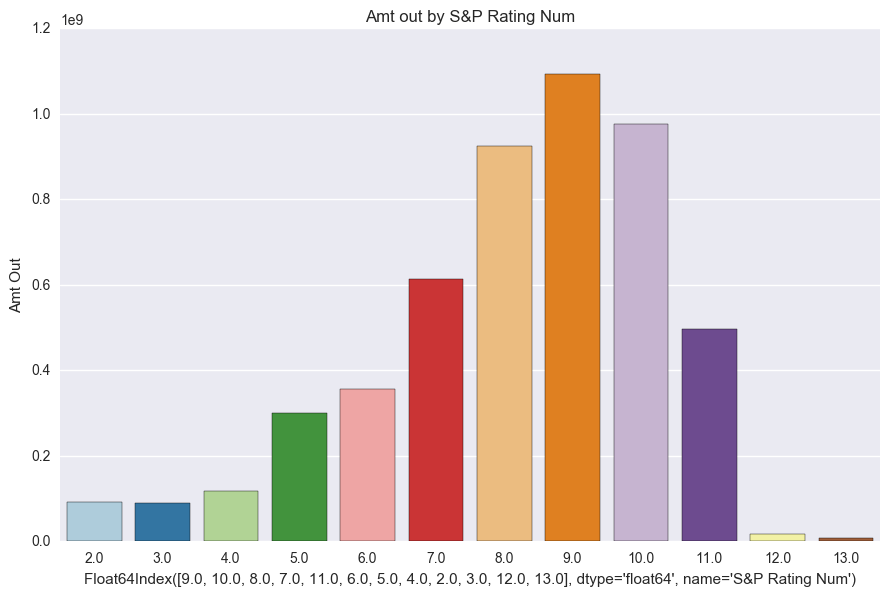

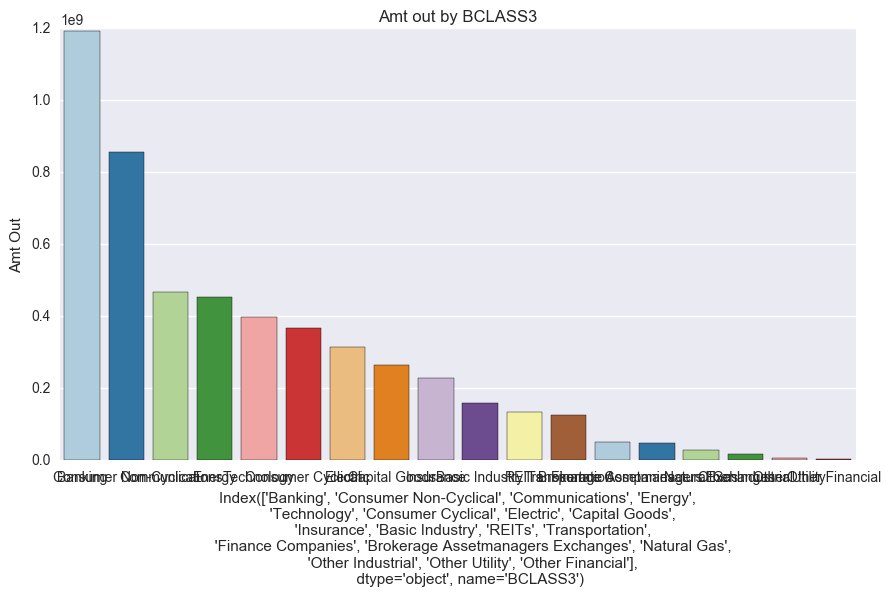

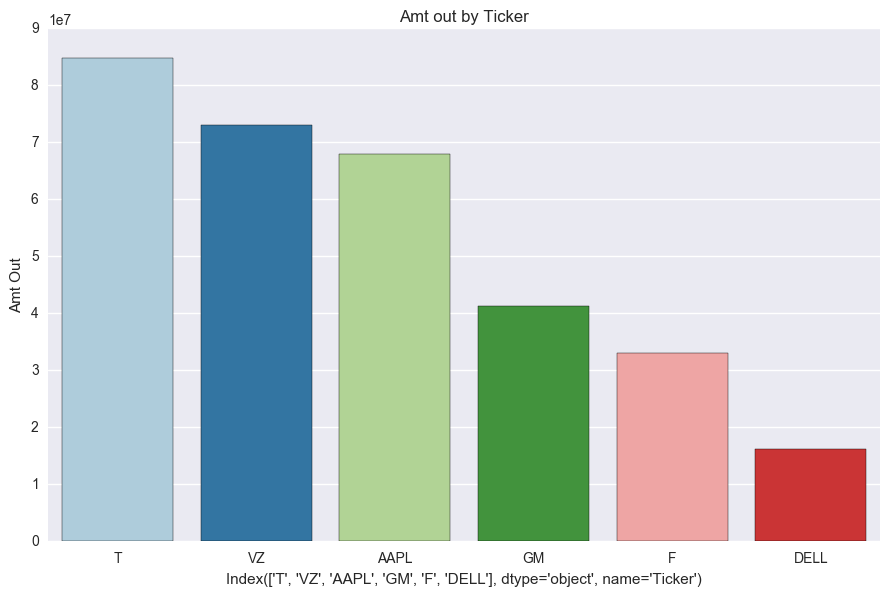

In [196]:
'''
EDA for amount outstanding across various ratings, sector, country, or issuer on a specific date 
field: categorical field
my_list: subset of values for field or empty list 
date: date as string, if nothing takes most recent
'''
def tot_amount_out(field, my_list = [], my_date = ''):
    if not my_date:
        my_date = df.date.iloc[-1]
    
    # if list is empty take all
    if not my_list:
        my_list = df[field].unique()
    
    #filter df
    date_mask = df.date == my_date    
    field_mask = df[field].isin(my_list)
    df_temp = df[date_mask & field_mask]
    
    group_df = pd.DataFrame(df_temp.groupby([field])['Amt Out'].sum().sort_values(ascending = False))
    sns.factorplot(group_df.index, 'Amt Out', data=group_df, kind = 'bar', size = 6, aspect = 1.5, palette="Paired")
    ax = plt.gca()
    ax.set_title("Amt out by " + field)

#example amount outstanding by rating
tot_amount_out('S&P Rating Num')

#example amount outstanding by sector
tot_amount_out('BCLASS3')

#example amount outstanding for a subset of tickers
tot_amount_out('Ticker', ['AAPL', 'DELL', 'T', 'VZ', 'F', 'GM'])

In [300]:
'''
Given an ISIN - return the average ISINs per ticker for a cohort or bonds.
Gives an estimate for count of similar bonds
Cohort is defined as same sector, rating
'''
def get_avg_num_cusips(isin):
    temp_df = df[df['date'] == df.date.iloc[-1]]
    sector = temp_df[temp_df['ISIN'] == isin]['BCLASS3'].iloc[0]
    rating = temp_df[temp_df['ISIN'] == isin]['S&P Rating Num'].iloc[0]

    temp_df = temp_df[(temp_df['BCLASS3'] == sector) & (temp_df['S&P Rating Num'] == rating)]
    
    my_avg = round(temp_df.groupby(['Ticker'])['ISIN'].count().sum()/len(temp_df.groupby(['Ticker'])['ISIN'].count()),2)
    print("For bonds from the {} sector with a rating of {}, there are on average {} similar bonds per ticker".format(sector, rating, my_avg))
    
get_avg_num_cusips('XS1523140942')
get_avg_num_cusips('US98420EAB11')
get_avg_num_cusips('US037735CV70')

For bonds from the Banking sector with a rating of 9.0, there are on average 6.7 similar bonds per ticker
For bonds from the Insurance sector with a rating of 7.0, there are on average 6.23 similar bonds per ticker
For bonds from the Electric sector with a rating of 8.0, there are on average 8.76 similar bonds per ticker


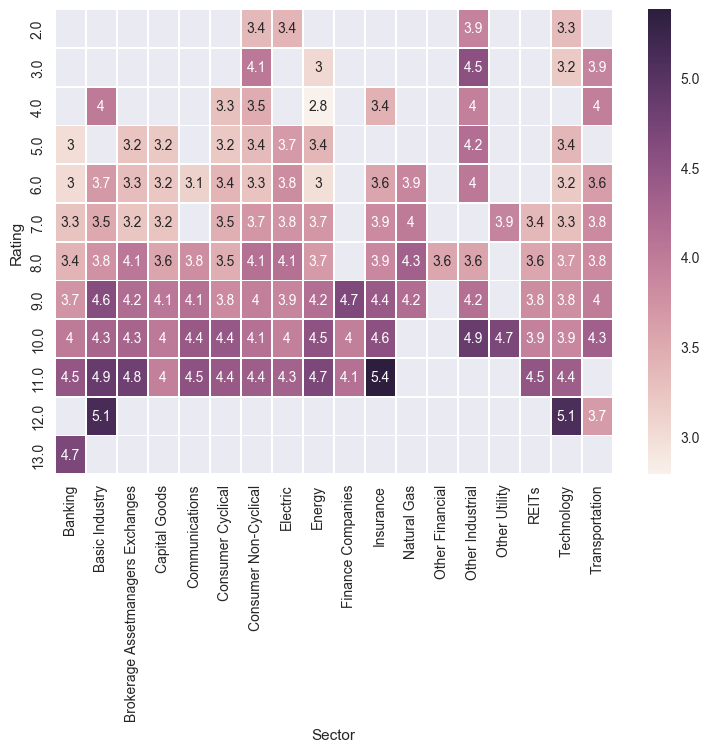

In [19]:
'''
create a heatmap showing available yield by sector and rating
weight the yield to worst by the market value
'''
df_temp = df[df['date'] == df.date.iloc[-1]]
df_temp = df_temp.dropna()
df_temp['market_value'] = (df_temp['Px Close'] + df_temp['Accrued Int (%)']) * df_temp['Amt Out']
group = df_temp.groupby(['BCLASS3', 'S&P Rating Num']).apply(lambda x: np.average(x['Yield to Mat'], weights= x['market_value']))
df_final = pd.DataFrame({'Sector':group.index.get_level_values(0), 
                         'Rating':group.index.get_level_values(1), 
                         'weighted YTW':group.values})
pivot = df_final.pivot("Rating", "Sector", "weighted YTW")
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot, annot=True,  linewidths=.5, ax=ax)
plt.show()

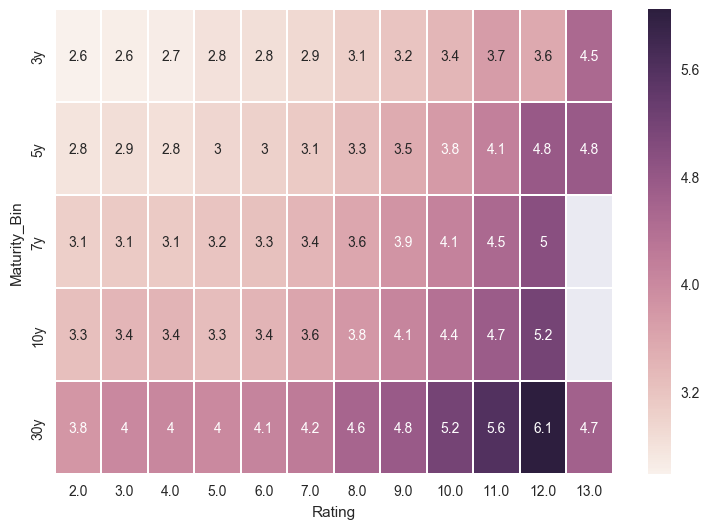

In [20]:
'''
create a heatmap showing available yield by maturity and rating
weight the yield to worst by the market value
'''
df_temp = df[df['date'] == df.date.iloc[-1]]
df_temp = df_temp.dropna()
df_temp['market_value'] = (df_temp['Px Close'] + df_temp['Accrued Int (%)']) * df_temp['Amt Out']
df_temp['Maturity_Bin'] = pd.cut(df_temp['Years to Mat'], bins = [0,4,6,8,11,1000], labels = ['3y', '5y', '7y', '10y','30y'])
group = df_temp.groupby(['Maturity_Bin', 'S&P Rating Num']).apply(lambda x: np.average(x['Yield to Mat'], weights= x['market_value']))
df_final = pd.DataFrame({'Maturity_Bin':group.index.get_level_values(0), 
                         'Rating':group.index.get_level_values(1), 
                         'weighted YTW':group.values})
pivot = df_final.pivot("Maturity_Bin", "Rating", "weighted YTW")
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pivot, annot=True,  linewidths=.5, ax=ax)
plt.show()

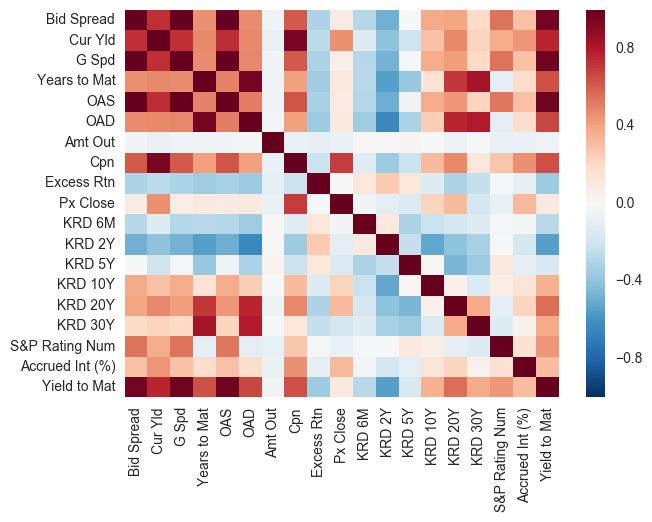

In [194]:
'''
look at correlations between variables non-categorical variables
'''
df_temp = df[df['date'] == df.date.iloc[-1]]
corr = df_temp.corr()
heatmap = sns.heatmap(corr, 
                      xticklabels=corr.columns.values,
                      yticklabels=corr.columns.values)

fig = heatmap.get_figure()
fig.set_size_inches(7, 5)


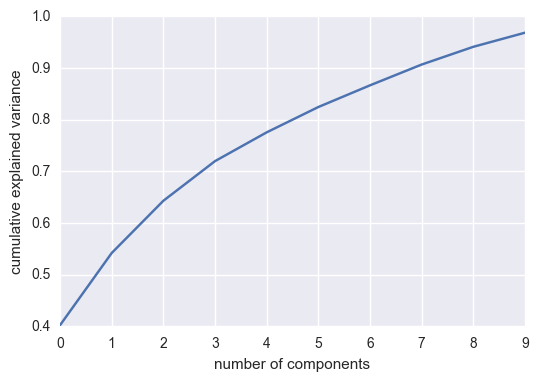

In [221]:
'''
Conduct a PCA analysis on non-categorical variables
'''

#get most recetn date
df_temp = df[df['date'] == df.date.iloc[-1]]

#remove missing rating / mty rows
df_temp = df_temp.dropna()

#list of categorical variables
cat_list = ['BCLASS3', 'Ticker', 'Class - Detail - Code']

#list of non-categorical variables
non_cat_list = ['Bid Spread', 'Cur Yld', 'G Spd', 'Years to Mat',
                'OAS', 'OAD', 'Amt Out', 'Cpn', 'Excess Rtn', 
                'Px Close', 'KRD 6M', 'KRD 2Y', 'KRD 5Y', 'KRD 10Y',
                'KRD 20Y', 'KRD 30Y', 'S&P Rating Num', 'Accrued Int (%)', 'Yield to Mat']

df_scaled = preprocessing.scale(df_temp[non_cat_list])

pca = decomposition.PCA(.95)
x = pca.fit_transform(df_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


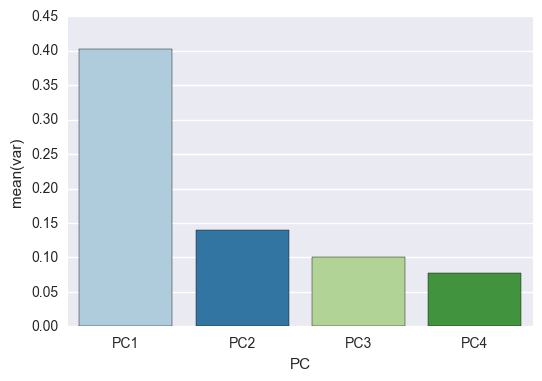

In [246]:
#use 4 components accounting for about ~78 of variance
pca = decomposition.PCA(n_components = 4)
pca.fit_transform(df_scaled)
df_pca = pd.DataFrame({'var':pca.explained_variance_ratio_,'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", data=df_pca, palette="Paired")

In [1]:
#print PCA coefficients 
df_pca_factors = pd.DataFrame(pca.components_, columns=list(df_temp[non_cat_list].columns))

print("\n PCA coefficients for PC1: \n")
print(df_pca_factors.iloc[0].sort_values(ascending = False))

print("\n PCA coefficients for PC2: \n")
print(df_pca_factors.iloc[1].sort_values(ascending = False))

NameError: name 'pd' is not defined

In [299]:
'''
calculate betas for ISIN in the index. Use 3-month (60 trading day betas)
regress isin excess return on market excses return beta = cov(ISIN_ret, market_ret)/var(market_ret)
measures systemtaic risk of a security in comparison to the market
= 1 : in line with the market
> 1 : more volatile
< 1 : less volatile
'''

#step 1: calculate market returns for the most recent 60 days in the data set using weighted average return
def market_ret_60d():
    '''
    returns a 60 day data frame with ISIN, daily excess return, 
    '''
    dates = df.date.unique()[-60:]
    df_temp = df[df.date.isin(dates)]
    df_temp['market_value'] = (df_temp['Px Close'] + df_temp['Accrued Int (%)']) * df_temp['Amt Out']
    returns = pd.DataFrame(df_temp.groupby('date').apply(lambda x: np.average(x['Excess Rtn'], weights= x['market_value'])), 
                        columns=['market_return'])
    merged = pd.merge(df_temp, returns, right_index=True, left_on='date')
    return merged

#step 2: use market returns to calculate betas
def calc_betas():
    returns_df = market_ret_60d()
    group = returns_df.groupby('ISIN')
    betas = group.apply(lambda x: np.cov(x['Excess Rtn'], x['market_return'])[0][1]/np.var(x['market_return']))
    return betas    

#step 3: append betas to most recent day of data
df_temp = df[df['date'] == df.date.iloc[-1]] #get most recent date
betas = pd.DataFrame(calc_betas(), columns=['beta'])
df_temp = pd.merge(df_temp, betas, right_index = True, left_on = 'ISIN')

df_temp[['ISIN', 'Ticker', 'BCLASS3','Cpn', 'Years to Mat', 'S&P Rating Num', 'beta']].head(15)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ISIN,Ticker,BCLASS3,Cpn,Years to Mat,S&P Rating Num,beta
1535117,US00037BAB80,ABBNVX,Capital Goods,2.875,3.17,7.0,-0.012045
1535118,US00037BAC63,ABBNVX,Capital Goods,4.375,23.17,7.0,1.659470
1535119,US00037BAD47,ABBNVX,Capital Goods,2.800,1.07,7.0,0.035258
1535120,US00037BAE20,ABBNVX,Capital Goods,3.375,4.07,7.0,0.162192
1535121,US00037BAF94,ABBNVX,Capital Goods,3.800,9.07,7.0,0.577244
1535122,US001055AJ19,AFL,Insurance,4.000,2.94,8.0,0.116095
1535123,US001055AL64,AFL,Insurance,3.625,4.27,8.0,0.039825
1535124,US001055AM48,AFL,Insurance,3.625,5.69,8.0,0.363334
1535125,US001055AP78,AFL,Insurance,3.250,6.02,8.0,0.399239
1535126,US001055AQ51,AFL,Insurance,2.875,7.60,8.0,0.396210
